<a href="https://colab.research.google.com/github/marcomoretto/VESPUCCI/blob/master/VESPUCCI_with_pyCOMPASS_use_case_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VESPUCCI use case n° 2

[VESPUCCI](https://vespucci.readthedocs.io/) is the gene expression database for grapevine and we can access it via its GraphQL interface, called [COMPASS](https://compass-.readthedocs.io/). The [pyCOMPASS](https://pycompass.readthedocs.io/) package is a Python package that wraps some functionalities to simplify communication with the [COMPASS](https://compass-.readthedocs.io/) interface.

In this second excercise we will use [VESPUCCI](https://vespucci.readthedocs.io/) together with other Python packages to create an integrated workflow that goes beyond the functionalities that [VESPUCCI](https://vespucci.readthedocs.io/) alone provides.

The goal here is to answer the following question: *which are the "biological processes" that get shutted down in leaves?*
To answer this question we will need to perform a GO enrichment analysis (using [goatools](https://github.com/tanghaibao/goatools)) on a subset of genes that are not expressed in leaf tissue.

In [ ]:
!pip install pycompass==0.8.1

In [ ]:
!pip install goatools
!pip install fisher
!pip install statsmodels
!pip install pydot

     |████████████████████████████████| 15.1MB 192kB/s 
     |████████████████████████████████| 153kB 36.4MB/s 
     |████████████████████████████████| 112kB 45.0MB/s 
  Created wheel for goatools: filename=goatools-1.1.6-cp37-none-any.whl size=15762836 sha256=586ac2ccdf151dffec756a8f3fb7d136653ada16a7368a07aa3c90f2bec3ce99
  Stored in directory: /root/.cache/pip/wheels/a1/cd/d8/0b540c04e3e003872d27360ff7579540be435e49af868f210f
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=ff94439deb93c58692b87a096dcf26288b61b232d71f63bb7d1a6ab6205d697b
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built goatools wget
  Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
     |████████████████████████████████| 153kB 28.9MB/s 
  Created wheel for fisher: filename=fisher-0.1.9-cp37-cp37m-linux_x86_64.whl size=297401 sha256=e5f445b702b1499d1

### Import the pyCOMPASS, GOATOOLS and other packages modules and classes

In [ ]:
from pycompass import Compendium, Connect, BiologicalFeature, Module, SampleSet, Plot, Annotation, Experiment, Sample, Platform, Ontology, Sparql
from IPython.core.display import HTML
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
from IPython.display import Image
import requests

### The Connect object represent our connection to the COMPASS GraphQL endpoint

In [ ]:
connect = Connect('http://compass.fmach.it/graphql')

### Let's use the TPM normalized values

In [ ]:
compendium = connect.get_compendium('vespucci', normalization='tpm')

### What is a module?
A *module* is VESPUCCI's basic **unit**. It is the result of every query performed and essentially it is a subset of the whole gene expression matrix, so it composed by some rows (genes) and some columns (samples or conditions) and each value is a normalized value for that specific gene in that specific sample or condition.

### Select leaf samples
Using a SPARQL query we can select only the samples annotated as leaf using the following triple template where [PO_0025034](http://www.ontobee.org/ontology/PO?iri=http://purl.obolibrary.org/obo/PO_0025034) is the [Plant Ontology](https://www.ebi.ac.uk/ols/ontologies/po) term for ***leaf***.

In [ ]:
sparql = "SELECT ?s ?p ?o " + \
    "WHERE { ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://purl.obolibrary.org/obo/PO_0025034> }"

leaf_samples = Sample.using(compendium).by(sparql=sparql)

### Now we will organize samples by their experiment ID and then select the experiment with most samples

In [ ]:
exp_samples = {}
for sample in leaf_samples:
  if sample.__experiment_id__ not in exp_samples:
    exp_samples[sample.__experiment_id__] = []
  exp_samples[sample.__experiment_id__].append(sample)

In [ ]:
biggest_experiment = sorted([(k, len(v)) for k,v in exp_samples.items()], key=lambda x:x[1], reverse=True)[0][0]

### Now we are ready to select all the leaf samples from the same experiment (the one that contains the most leaf samples overall)

In [ ]:
samples = exp_samples[biggest_experiment]

### Get the SampleSets
Now that we have the samples we need to retrieve the **SampleSets** objects for this specific normalization (the TPM normalization).



In [ ]:
leaf_ss = SampleSet.using(compendium).by(samples=samples)

### Get the genes
We will need to use all genes

In [ ]:
genes = BiologicalFeature.using(compendium).get()

### Create the module
Now that we have both the genes (**BiologicalFeatures**) and the **SampleSets**, we can create our **Module** and retrieve the TPM-normalized values.

In [ ]:
module = Module.using(compendium).create(samplesets=leaf_ss, biofeatures=genes)

### Format the values
In order to better handle the module values and get rid of NaNs, we will create a Pandas DataFrame starting from our Module values (we are using log2), with genes as rows and SampleSets as columns.

In [ ]:
df = pd.DataFrame(np.log2(module.values + 0.01), columns=[ss.name for ss in module.sample_sets], index=[bf.name for bf in module.biological_features])
df = df.T.fillna(df.mean(axis=1)).T
data = df.replace([np.inf, -np.inf], np.nan).dropna().values

### Fit a 2-component Gaussian Mixture Model
The idea to fit a 2-component Gaussian Mixture Model comes from the [following paper](https://www.embopress.org/doi/full/10.1038/msb.2011.28): Hebenstreit, D., Fang, M., Gu, M., Charoensawan, V., van Oudenaarden, A., & Teichmann, S. A. (2011). *RNA sequencing reveals two major classes of gene expression levels in metazoan cells*. Molecular systems biology, 7(1).

In a nutshell the log2-TPM distribution is fitted with a 2-component GMM where one component represent the lowly expressed genes while the other one represents the highly expressed genes. With the following plot we can have a visual representation of what lowly expressed genes means and intuitively pick-up a threshold for genes that are unlikely to be expressed at all.


In [ ]:
gmm = GaussianMixture(n_components=2)
gmm.fit(data.reshape(-1, 1))

x = np.linspace(-15, 15, 1000)

y1 = norm.pdf(x, gmm.means_[0][0], np.sqrt(gmm.covariances_[0][0])) * gmm.weights_[0]
y2 = norm.pdf(x, gmm.means_[1][0], np.sqrt(gmm.covariances_[1][0])) * gmm.weights_[1]

### Plot the data distribution and the fitted model


In [ ]:
fig = px.histogram(data, x=0, histnorm='probability density')
fig.add_trace(go.Scatter(
    x=x, y=y1, line=dict(color='red'), name='Highly expressed'
))
fig.add_trace(go.Scatter(
    x=x, y=y2, line=dict(color='green'), name='Lowly expressed'
))
fig.add_trace(go.Scatter(
    x=x, y=y1 + y2, line=dict(color='blue'), name='Gaussian mixture'
))
fig.update_layout(title='Leaf samples Log2-TPM distribution',
                   xaxis_title='Log2-TPM',
                   yaxis_title='Density (normalized)')


### Choose a cutoff for non-expressed genes
With the following plot we can (arbitrarily) choose a log2-TPM cutoff value to distinguish the portion of expressed genes from the non-expressed genes. We chose to set this cutoff at -0.7, that is roughly intersection of the two components.

In [ ]:
never_expressed_in_leaf = set(df[(df < -0.7).all(axis=1)].index)

This is the percentage of genes not expressed in leaf

In [ ]:
print(len(never_expressed_in_leaf) / data.shape[0] * 100.0, '%')

8.060416817950767 %


### Retrieve the GO annotation
Now it's time to retrieve all the GO terms for our genes and see if in the subset of genes never expressed in leaf there are GO terms that are over-represented compared to the full annotation.

We might want to use the Annotation class to retrieve the annotation for all our genes filtering out the GO terms, but to avoid the overhead given by the large number of genes to use, it is better to perform a lower level operation and go directly with a SPARQL query for the annotation terms we are interested in. 

In [ ]:
Annotation(genes[:5]).get_triples()

[['VIT_10s0116g00040', 'Gene Alias', 'Vv10s0116g00040'],
 ['GO_0006810', 'name', 'transport'],
 ['VIT_10s0116g00060', 'Annotation', 'GO_0006810'],
 ['GO_0019684', 'name', 'photosynthesis, light reaction'],
 ['VIT_10s0116g00060', 'Annotation', 'GO_0019684'],
 ['GO_0055114', 'name', 'oxidation-reduction process'],
 ['VIT_10s0116g00060', 'Annotation', 'GO_0055114'],
 ['VIT_10s0116g00060', 'Gene Alias', '1.6.5.3'],
 ['VIT_10s0116g00060', 'Gene Alias', 'EC:1.6.5.3'],
 ['VIT_10s0116g00060', 'Gene Alias', 'VIT_10s0116g00060'],
 ['VIT_10s0116g00060', 'Gene Alias', 'Vv10s0116g00060'],
 ['VIT_10s0116g00070', 'Gene Alias', 'E0CVJ7'],
 ['VIT_10s0116g00070', 'Gene Alias', 'Vv10s0116g00070'],
 ['VIT_10s0116g00080', 'Gene Alias', 'B9HI95'],
 ['VIT_10s0116g00080', 'Gene Alias', 'POPTR_0008s08900g'],
 ['VIT_10s0116g00080', 'Gene Alias', 'Vv10s0116g00080'],
 ['GO_0048544', 'name', 'recognition of pollen'],
 ['VIT_10s0116g00150', 'Annotation', 'GO_0048544'],
 ['GO_0006468', 'name', 'protein phosphorylati

So let's avoid the previous code that we ran for only 5 genes and go with the following instead, that is a SPARQL query that will return all the triples where a biofeature is annotated (Annotation is the term [NCIT_C44272](http://purl.obolibrary.org/obo/NCIT_C44272)) with a term starting with **'GO_'**

In [ ]:
sparql = "SELECT ?s ?o WHERE {?s <http://purl.obolibrary.org/obo/NCIT_C44272> ?o FILTER (strstarts(str(?o), 'GO_'))}"
triples = Sparql.using(compendium).execute_query(sparql, 'biofeature')

Now let's create the association object required by *goatools* and get rid of the underscore '_' in the annotation terms and replace it with the ':' symbol.

In [ ]:
go_assoc = {'ALL': {}}
gene_ids = {g.id:g.name for g in genes}
for t in triples:
  gid = gene_ids[t[0]]
  if gid not in go_assoc['ALL']:
    go_assoc['ALL'][gid] = set()
  go_assoc['ALL'][gid].add(t[1].replace('_', ':'))

### Setup the GO analysis
VESPUCCI provides a basic enrichment tool, but to perform a more complete analysis we will rely on an external package such as `goatools`.
To start the GO analysis we will download the basic GO and the Plant Slim GO and create both DAGs objects.

In [ ]:
goslim_url = 'http://current.geneontology.org/ontology/subsets/goslim_plant.obo'
r = requests.get(goslim_url, allow_redirects=True)
open('goslim_plant.obo', 'wb').write(r.content)
oboslimdag = GODag("goslim_plant.obo")

goslim_plant.obo: fmt(1.2) rel(None) 161 GO Terms


In [ ]:
obo_fname = download_go_basic_obo()
obodag = GODag("go-basic.obo")

requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo

go-basic.obo: fmt(1.2) rel(2021-05-01) 47,284 GO Terms


### Prepare GOEnrichment study with the Plant Slim

In [ ]:
study = GOEnrichmentStudyNS(
        go_assoc['ALL'].keys(),
        go_assoc,
        oboslimdag,
        propagate_counts = False,
        alpha = 0.05,
        methods = ['fdr_bh'])


Load ALL Gene Ontology Analysis ...
100% 15,136 of 15,136 population items found in association


### Perform the enrichment analysis using our subset of genes and display the GO graph result

In [ ]:
goea_results_all = study.run_study(never_expressed_in_leaf, prt=None)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
plot_results("never_expressed_in_leaf_slim_{NS}.png", goea_results_sig)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



    4 usr   9 GOs  WROTE: never_expressed_in_leaf_slim_BP.png


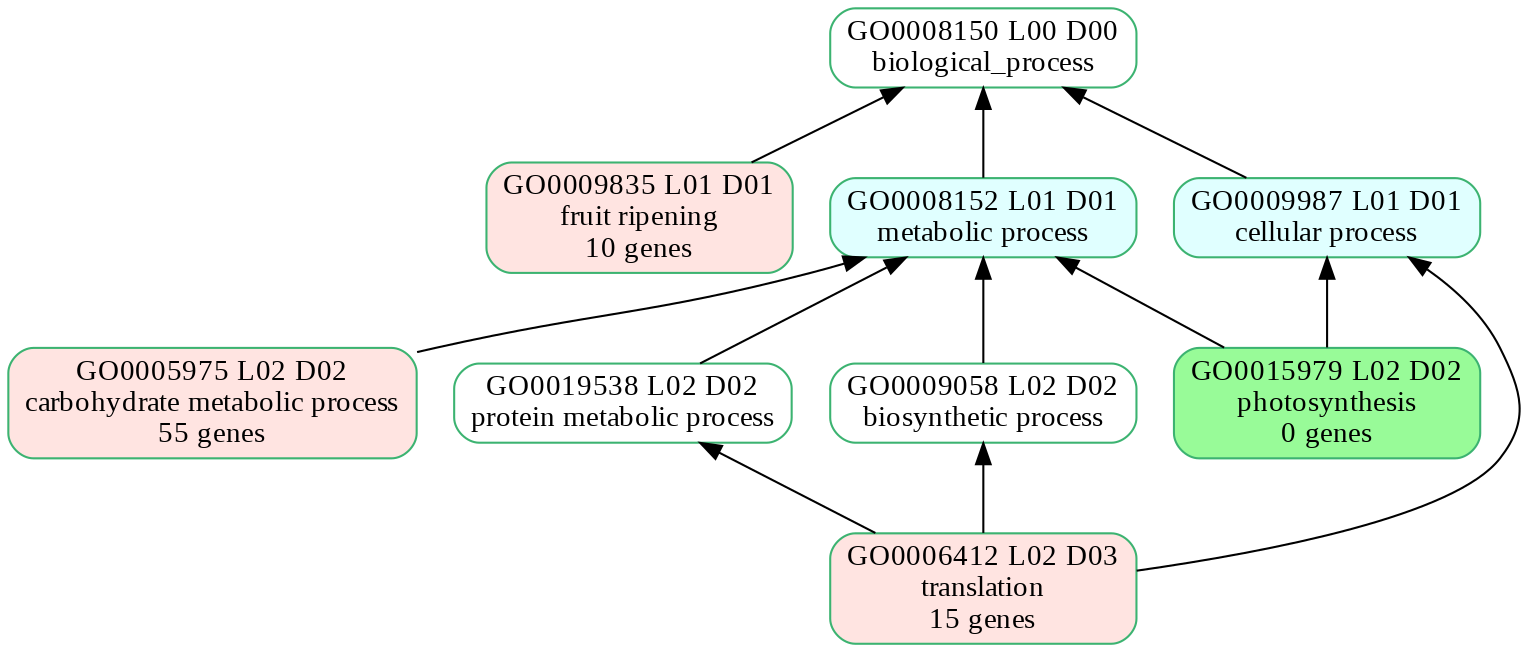

In [ ]:
Image(filename='never_expressed_in_leaf_slim_BP.png')

### Let's perform the same analysis but with the full GO DAG this time

In [ ]:
study = GOEnrichmentStudyNS(
        go_assoc['ALL'].keys(),
        go_assoc,
        obodag,
        propagate_counts = False,
        alpha = 0.05,
        methods = ['fdr_bh'])


Load ALL Gene Ontology Analysis ...
100% 15,136 of 15,136 population items found in association


In [ ]:
goea_results_all = study.run_study(never_expressed_in_leaf, prt=None)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
plot_results("never_expressed_in_leaf_complete_{NS}.png", goea_results_sig)

   12 usr  81 GOs  WROTE: never_expressed_in_leaf_complete_BP.png


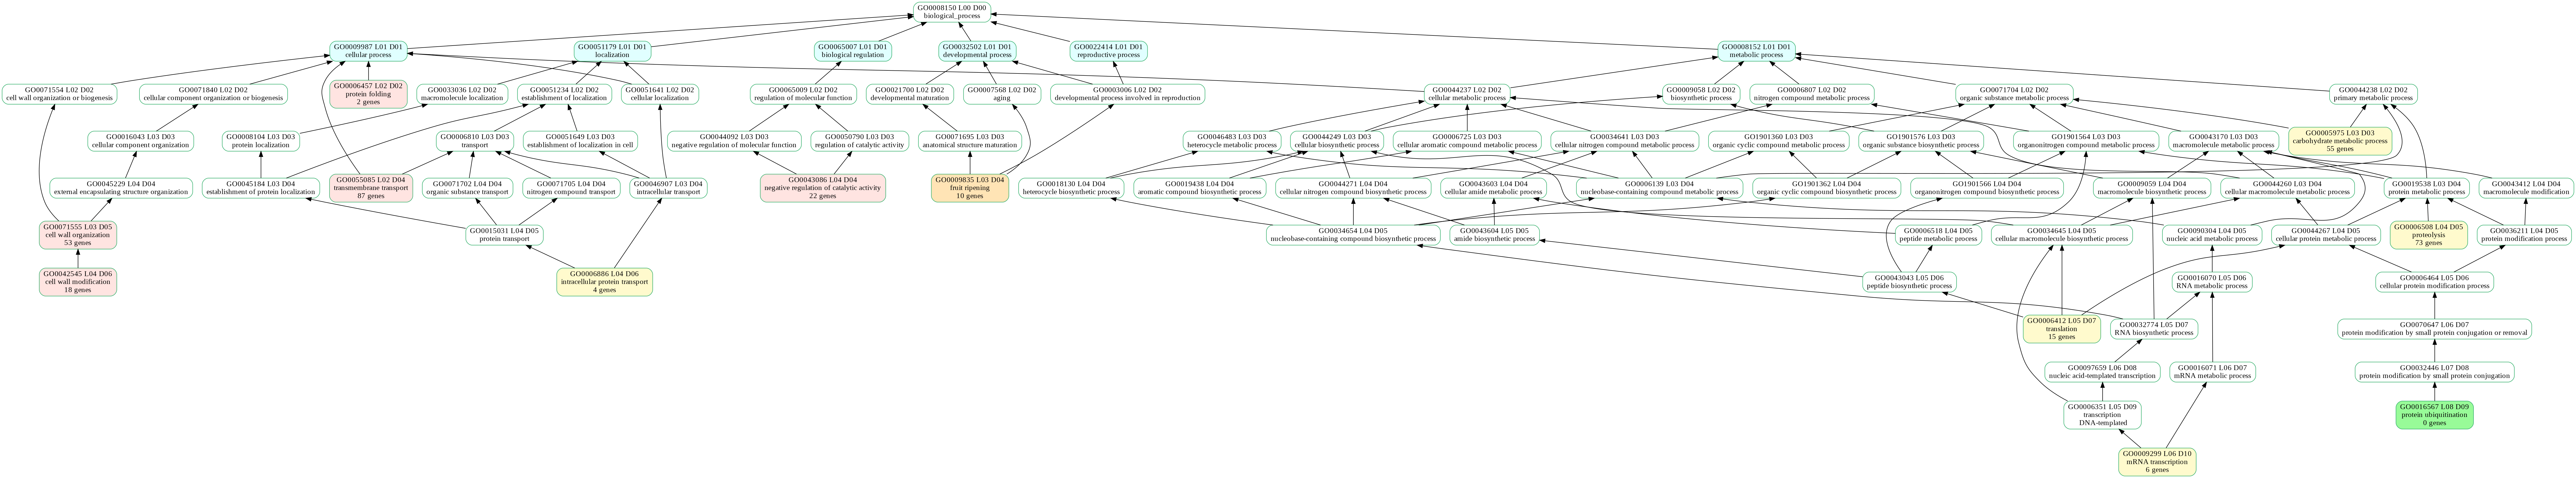

In [ ]:
Image(filename='never_expressed_in_leaf_complete_BP.png')